<img style="float: left;" src="images\EP_Logo.png" alt="UoE" width="300px"/>
<img style="float: right;" src="images\UoE_Logo.png" alt="UoE" width="300px"/>
<img style="float: left;" src="images\urban_rural_scape.png" alt="UoE" width="1000px"/>

# Gaussian Plume Modelling
Jupyter notebook for ECSC09005 Environmental Pollution  
author: John Moncrieff *for* Session 2020-21  [version 0.12, latest 19:57, 8 Feb 2021]
## Background
As discussed in the lecture series, the gaussian plume model has been applied in many different situations either to understand a given air pollution episode or to predict the impact of say a new factory or motorway on future air quality in a particular area. In this jupyter notebook, I want us to explore the sensitivity of ground-level concentration of various pollutants to changes in driving variables such as wind speed and direction and chimney height. Let's examine a real-life example where a local community has been impacted by gas flaring from a local industrial complex in Fife, just north of Edinburgh. If you want some background on this example, have a look at a couple of web reports from the BBC: https://www.bbc.co.uk/news/uk-scotland-edinburgh-east-fife-51498166  and https://www.bbc.co.uk/news/uk-scotland-edinburgh-east-fife-49720751 
<img style="float: right;" src="images\Mossmorran_Flaring.png" alt="Mossmorran flaring" width="360px"/></p>
## Imports
Let's start by importing some libraries to the environment:
- *matplotlib inline* for creating inline plots
- *scipy* for various mathematical functions
- *pandas* to order and sort data in a convenient Table-like format
- *numpy* for numerical routines
- *matplotlib* for plotting data
- *ipywidgets* for interactivity
- *config* for python code that just takes up space in the main notebook
- *pyproj* to allow us to convert from GPS coordinates to eastings and northings
- *requests* so we can download a streetmap via a URL query
- *pil* to handle images

In [1]:
%matplotlib inline
import numpy as np
import sys
from scipy.special import erfcinv as erfcinv
import tqdm as tqdm
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import ticker, cm
from src import gauss_func, calc_sigmas, smooth
from src import streetimg as stmap
from src.ltgpinterface import ltgpinterface
from src.cfg import cfg
from src import ytv, gpdraw, tpdraw, sigmaplot, main
from pyproj import Proj, transform
import ipywidgets as widgets
from ipywidgets import AppLayout, GridspecLayout
from IPython.display import display
import windrose
from windrose import WindroseAxes

print('imports OK')

imports OK


The gaussian plume equation requires a number of parameters such as wind speed, the effective height of emission, emission strength and the spreading parameters $\sigma_y$ and $\sigma_z$ :  
>$\large x = \frac{Q}{\ \pi\sigma_y \sigma_z u} \exp[ - \frac{1}{\ 2} (\frac{y}{\ \sigma_y})^2] \exp[ - \frac{1}{\ 2} (\frac{H}{\ \sigma_z})^2]$  
where  
$x$ is the ground-level concentration (typically $\mu g m^{-3}$)  
$Q$ is the source emission strength (often $g \ s^{-1}$)  
$u$ is the surface wind speed (usually $m \ s^{-1}$)  
$\sigma_y, \sigma_z$ are the spreading parameters in the $y$ and $z$ directions respectively (units of $m$) and functions of atmospheric stability  
$H$ is the effective plume height ($m$)  
$exp$ is the base of natural logarithms ie the exponential function


### Pasquill dispersion classes  
(Surface wind speed in $m \ s^{-1}$)

| Insolation   | Cloud cover       | Wind Speed | Wind Speed | Wind Speed | Wind Speed | Wind Speed |
|--------------|-------------------|------------|------------|------------|------------|------------|
|              |                   | <2         | 2-3        | 3-5        | 5-6        | >6         |
| Day          | Strong            | A          | A-B        | B          | C          | C          |
|              | Moderate          | A-B        | B          | B-C        | C-D        | D          |
|              | Slight            | B          | C          | C          | D          | D          |
| Day or night | Overcast          | D          | D          | D          | D          | D          |
| Night        | Thin or CC >= 0.5 |            | E          | D          | D          | D          |
|              | CC <=0.4          |            | F          | E          | D          | D          |
|              |                   |            |            |            |            |            |


How do we get $\sigma_y$ and $\sigma_z$?

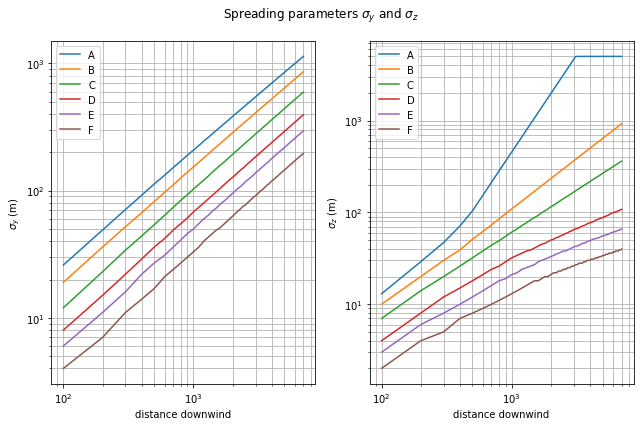

In [2]:
# There are many functions to describe how the plume spreads in the horizontal
# and vertical. Most use some sort of power law such as $sigma_n = ax^b$
# The one we have programmed gives this output:
sigmaplot.sigmaplot()

### First,  prepare a background image.
This shows the local towns and roads over which we'll project the output from the model. This cell only needs to be run once at the start of the program.

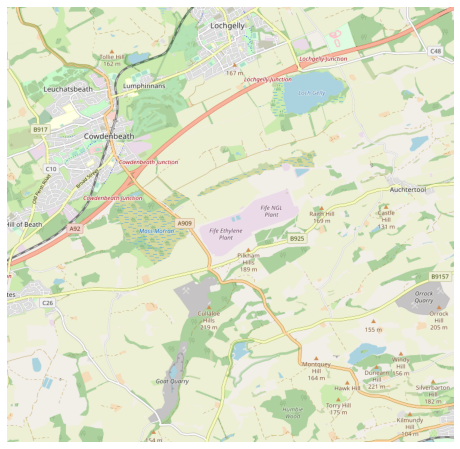

In [3]:
# Get the map Data
# Get more than one tile for a 4 x 4 km box centred on
# the main sources of emission - Fife Ethylene Plant in this example
# I used Google Earth to find the lat-lon coordinates
lat_max = 56.132276
lat_min = 56.060534
lon_min = -3.3733
lon_max = -3.244456
mp = stmap.stmap(lat_max,lat_min,lon_min,lon_max,13)
img=mp.run()    # image now stored in memory for later use. 
# If the map below looks OK, proceed to initialise the model.

### Configuration - edit the input options below as appropriate.
Now let's load up some default information that will provide the initial configuration of variables such as windspeed ($u$) and wind direction, stack height and location etc. You will keep coming back to this cell to change parameters as part of the simulation.  The units of heat output are MW; Source strength is in  g s$^{-1}$.

In [4]:
fd = ltgpinterface()                    # create the selection boxes via an interface
widgets.VBox(children=[fd.h0, fd.h1, fd.h2, fd.h3, fd.h4])    # Decide if flaring is from a tall stack or from ground sources
# Ground sources are assumed to emit from a height of 5 m above the ground with no heat ouput
# Assume 3 ground sources equal the total that would be emitted from a single tall stack

In [5]:
widgets.VBox(children=[fd.h8, fd.h5, fd.h7])    # what weather conditions?

<div class="alert alert-block alert-info">Next we do the calculations and show the results on the map we created. Depending on how many stacks you've chosen and the number of days to model, this might take several seconds to complete. A progress bar shows, well, progress. (Actually, I've limited you to 1 stack and just an hour's simulation for this exercise!)</div>

 11%|█         | 13/121 [00:00<00:00, 126.10it/s]

1


/Users/jbm/ownCloud/DocSyncUoE/Software/python/jupyter/pyltgp/src/gauss_func.py:31: RuntimeWarning: invalid value encountered in arccos
  subtended = np.arccos(dot_product/(magnitudes+1e-15))
100%|██████████| 121/121 [00:00<00:00, 150.21it/s]
/Users/jbm/ownCloud/DocSyncUoE/Software/python/jupyter/pyltgp/src/gpdraw.py:69: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xp, yp, data, alpha=0.25,levels=[5e0, 1e1, 5e1, 1e2, 5e2,1e3,5e3,5e4],


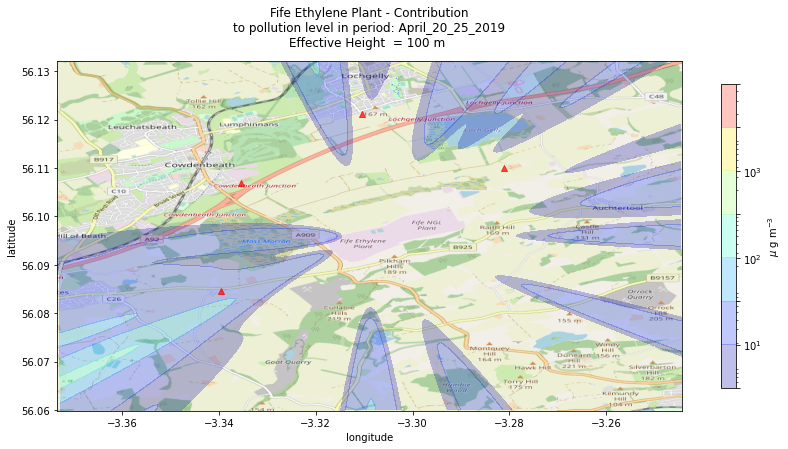

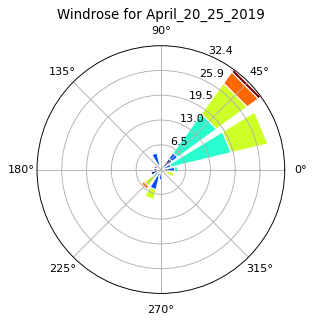

In [8]:
c=cfg(fd.stack,fd.stabls,fd.wvar)      # make a copy of the configuration
                                       # and then RUN the model
bts = False                            # boolean for timeseries
headers=['time','u','drct','stability']
if c.stack["ts"]=='timeseries':
    df1 = pd.read_csv('fepwx_'+fd.datetouse[0]+'.csv', sep=',', skiprows=1, header=None, names=headers)
    df1.set_index('time')
    c.wind_dir=df1["drct"].astype(float)
    c.wind_speed=df1["u"].astype(float)
    c.stability=df1["stability"].astype(int)
    bts = True

# For all times...
C1 = np.zeros((len(c.x), len(c.y), len(c.wind_dir)))

for i in tqdm.tqdm(range(0, len(c.wind_dir))):
    for j in range(0, c.stacks):
        C = np.ones((len(c.x), len(c.y)))
        C = gauss_func.gauss_func(c.Q[j], c.wind_speed[i], c.wind_dir[i], c.x, c.y, c.z,
                       c.stack_x[j], c.stack_y[j], c.H[j], c.Dy, c.Dz, c.stability[i])
        C1[:, :, i] = C1[:, :, i] + C

# Get the co-ordinates of the receptors to plot
l = fd.recepstouse
rlist=[]
for jj in range(0,len(l)):
    # What is the diffference in m between central point on map and this receptor
    xoffset = int(fd.receptors[l[jj]]['utm_e'] - c.UTM_easting)
    # and the diffference in units of m between central point on map and this receptor
    yoffset = int(fd.receptors[l[jj]]['utm_n'] - c.UTM_northing)
    rlist.append((xoffset,yoffset))
     
# SECTION 4: Plot the results
dlist=[c.output,c.UTM_easting,c.UTM_northing,c.x,c.y,
       fd.stack["stab"],fd.stack["wdirn"],fd.stack["fheight"],fd.stack["fwind"],
       rlist, fd.datetouse[0],bts]
gpdraw.gpdraw(C1,img,dlist)

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

if bts:
    # https://github.com/python-windrose/windrose/
    # You'll need to install this package eg 'conda install -c conda-forge windrose'
    #fig, ax=plt.subplots()
    ws = df1['u']
    wd = df1['drct']
    ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
    set_size(3,3)
    plt.title("Windrose for "+fd.datetouse[0])
    plt.show()

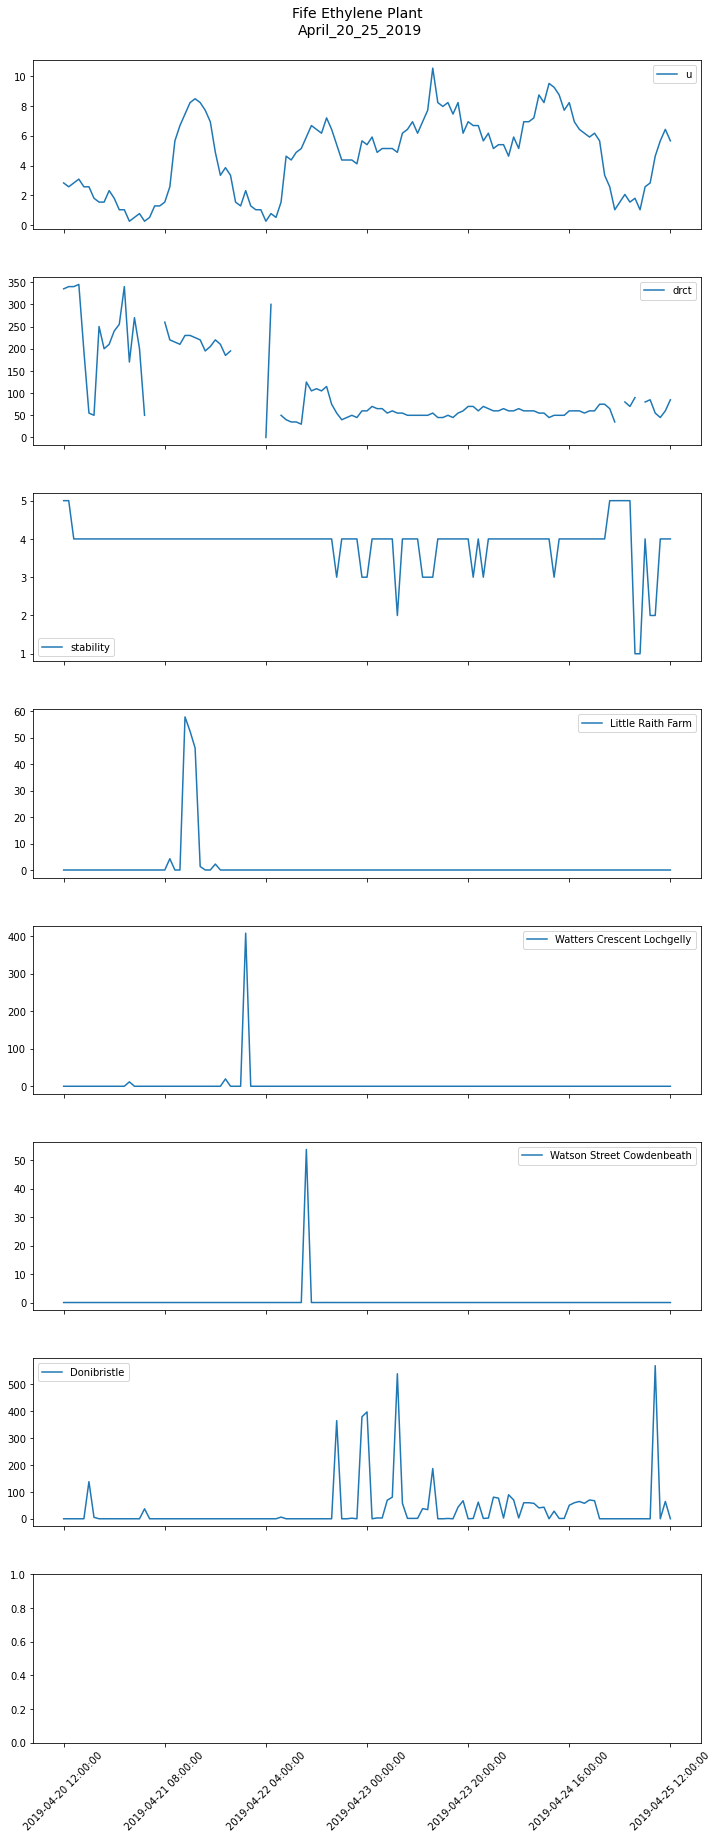

In [9]:
if c.stack['ts']=='manual':
    l = fd.recepstouse
    tlist=[]
    for jj in range(0,len(l)):
        # What is the diffference in units of dx between central point on map and this receptor
        xoffset = int(((fd.receptors[l[jj]]['utm_e']) - c.UTM_easting)/c.dxy)
        # and the diffference in units of dy between central point on map and this receptor
        yoffset = int((fd.receptors[l[jj]]['utm_n'] - c.UTM_northing)/c.dxy)
        tlist.append(C1[int(len(c.y)/2+yoffset)][int(len(c.x)/2+xoffset)][0]*1e6)
    rtlist=list(zip(l, tlist))
    df2 = pd.DataFrame(rtlist, columns=['Receptor','GLC (ug m-3)'])
    pd.options.display.float_format = '{:,.2f}'.format
    print(df2)

if c.stack['ts']=='timeseries':
    l = fd.recepstouse
    for jj in range(0,len(l)):
        # What is the diffference in units of dx between central point on map and this receptor
        xoffset = int(((fd.receptors[l[jj]]['utm_e']) - c.UTM_easting)/c.dxy)
        # and the diffference in units of dy between central point on map and this receptor
        yoffset = int((fd.receptors[l[jj]]['utm_n'] - c.UTM_northing)/c.dxy)
        tlist=[]
        for i in range(0,len(c.wind_dir)):
            tlist.append(C1[int(len(c.y)/2+yoffset),int(len(c.x)/2+xoffset),i]*1e6)
        df1[fd.recepstouse[jj]]=tlist
    # Draw the weather data and, if requested, the time series for each receptor
    df1.set_index('time')
    r, c = df1.shape
    cols = list(df1.columns.values.tolist())
    del cols[0]
    tpdraw.tpdraw(c, df1, cols, fd)



<div class="alert alert-block alert-info">At this point, you can go back to the configuration cell and chose something else to change eg a different wind speed or direction, a different atmospheric stability, more heat in the plume to change the effective height of emission etc.</div>

In [ ]:
# The Scottish Environmental Protection Agency (SEPA) are obviously 
# closely involved in monitoring air quality and noise pollution at Mossmorran:
ytv.display_yotube_video("https://youtu.be/G2s31TFVR7U", width=800, height=600)
# Sometimes YouTube won't play nicely so the direct link is:
# https://www.youtube.com/watch?v=G2s31TFVR7U

<div class="alert alert-block alert-info">Process some suitable weather data. Only need to do this for each time period of interest. Indeed, do this before running any of the above cells. </div>

### Weather data

In [ ]:
inpath = 'src/'
from pysolar.solar import *
import pytz
import datetime

# Get the name of the input file with raw weather data from JCMB
infilename = inpath+'EGPH_Mar_20.csv'
headers = ['station', 'valid', 'tmpc', 'dwpc', 'drct', 'sknt', 'skyc1', 
           'skyc2','skyc3','skyl1','skyl2','skyl3']

### Have to clean up the original data file since there's a mixture of numbers and strings (in skycn columns)
### and Pandas only takes one type of object at a time ie all numbers OR all strings etc but not both.
### So - replaced the skycn code with an integer number as follows:
### few = 0, skt = 1, bkn = 2, ovc = 3, ncd = 4, nsc = 5, VV = 6
### where the following Table converts to oktas of cloud cover:
###
###   Abbreviation   Oktas          Code used in skyc1 column
###      few         1-2                0
###      skt         3-4                1
###      bkn         5-7                2
###      ovc         8                  3
###      ncd         no cloud detcd     4
###      nsc         nil cloud          5
###      VV          cannot see cloud   6
###                    ie fog
### see: https://en.wikipedia.org/wiki/METAR#International_METAR_codes

df = pd.read_csv(infilename, sep=',', skiprows=1, header=None, names=headers)
df['skyc1'] = df['skyc1'].str.replace('FEW','0')
df['skyc1'] = df['skyc1'].str.replace('SCT','1')
df['skyc1'] = df['skyc1'].str.replace('BKN','2')
df['skyc1'] = df['skyc1'].str.replace('OVC','3')
df['skyc1'] = df['skyc1'].str.replace('NSC','5')
df['skyc1'] = df['skyc1'].str.replace('VV','6')
df['skyc2'] = df['skyc2'].str.replace('FEW','0')
df['skyc2'] = df['skyc2'].str.replace('SCT','1')
df['skyc2'] = df['skyc2'].str.replace('BKN','2')
df['skyc2'] = df['skyc2'].str.replace('OVC','3')
df['skyc3'] = df['skyc3'].str.replace('FEW','0')
df['skyc3'] = df['skyc3'].str.replace('SCT','1')
df['skyc3'] = df['skyc3'].str.replace('BKN','2')
df['skyc3'] = df['skyc3'].str.replace('OVC','3')
df['skyc3'] = df['skyc3'].str.replace('NSC','5')
df['skyc3'] = df['skyc3'].str.replace('VV','6')
# convert sky codes to a number so they can be plotted
df[['skyc1', 'skyc2', 'skyc3']] = df[['skyc1', 'skyc2', 'skyc3']].apply(pd.to_numeric)

# Make the timestamp the index for the file
df['time'] = pd.to_datetime(df['valid'], format='%Y-%m-%d %H:%M')
df.set_index('time', inplace=True)
# Convert METAR speed in knots to metres per second
df['u'] = df['sknt']* 0.5144

# now calculate max potential hourly solar radiation at Cowdenbeath
# https://earthscience.stackexchange.com/questions/14491/how-to-calculate-the-solar-radiation-at-any-place-any-time
#
startTime = pd.to_datetime(df.index[0])
year = startTime.year   
month = startTime.month
day = startTime.day
hour = startTime.hour
minute = startTime.minute
start = datetime.datetime(year, month, day, hour, minute, tzinfo=datetime.timezone.utc)
endTime = pd.to_datetime(df.index[-1])

lat, lon = 56.11194, -3.34426  # Cowdenbeath
# Calculate radiation every hour in the year currently selected
maxrad = list()
r, c = df.shape    # how many rows and columns are in the original dataframe?

for ihr in range(0, r):
    date = start + datetime.timedelta(hours=ihr)
    altitude_deg = get_altitude(lat, lon, date)
    if altitude_deg <= 0:
        smax = 0.
    else:
        smax = radiation.get_radiation_direct(date, altitude_deg)
    maxrad.append(smax)

# add the new list to the existing dataframe
df['solar'] = maxrad

# Take the mean over 60 minutes ie 60T 
# but note that observations are at 20 minutes past the hour and 10 minutes to - so need to fix this.
df=df.resample('60T').mean()
# Put all the data into ONE big plot
df.plot(subplots=True, figsize=(10, 10), title = 'Edinburgh Airport METAR reports August 12-21 2019')
plt.show()

In [ ]:
# Now get some stabilities per hour as a first guess
# We need a dataset with windspeed, wind direction and atmopsheric stability
# Now we have all we need in one dataframe - wind speed, irradiance and cloudiness
# NB - this is done a year-by-year basis at the moment

# Set up conditions so we can work out the stability on a per half-hour basis
# A = 1, B = 2, C = 3, D = 4, E = 5, F = 6
# Add in a stability column and make them all neutral to start ie code 4 (= Pasquill D)
df['stability'] = 4
#print(df['stability'].head(5))
#print(df.head())

# Must be a more pythonic way of doing this using list comprehension for example?
# The order of operation here is important

# Daytime, strong sunshine, windy = Pasquill 'C'
df['stability'] = np.where((df['u'] > 5)
                           & (df['solar'] > 500)
                           & (df['skyc1'] >2), #Identifies the case to apply to
                           3,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, strong sunshine, light-strong winds = Pasquill 'B'
df['stability'] = np.where((df['u'] < 5)
                           & (df['solar'] > 500)
                           & (df['skyc1'] <2), #Identifies the case to apply to
                           2,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, strong sunshine, light winds = Pasquill 'A'
df['stability'] = np.where((df['u'] < 2)
                           & (df['solar'] > 500)
                           & (df['skyc1'] ==0), #Identifies the case to apply to
                           1,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, moderate sunshine, windy = Pasquill 'C'
df['stability'] = np.where((df['u'] > 5)
                           & (df['solar'] < 500)
                           & (df['skyc1'] >2), #Identifies the case to apply to
                           3,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, moderate sunshine, light-strong winds = Pasquill 'B'
df['stability'] = np.where((df['u'] < 5)
                           & (df['solar'] < 500)
                           & (df['skyc1'] <2), #Identifies the case to apply to
                           2,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, moderate sunshine, light winds = Pasquill 'A'
df['stability'] = np.where((df['u'] < 2)
                           & (df['solar'] < 500)
                           & (df['skyc1'] <=1), #Identifies the case to apply to
                           1,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, slight sunshine, light-strong winds = Pasquill 'C'
df['stability'] = np.where((df['u'] < 5)
                           & (df['solar'] < 200)
                           & (df['skyc1'] ==1), #Identifies the case to apply to
                           3,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, slight sunshine, light-strong winds = Pasquill 'B'
df['stability'] = np.where((df['u'] < 2)
                           & (df['solar'] < 200)
                           & (df['skyc1'] ==0), #Identifies the case to apply to
                           2,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected

# Overcast day or night
df['stability'] = np.where((df['skyc1'] ==3), #Identifies the case to apply to
                           4,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Nightime >= 0.5 oktas = Pasquill 'E'
df['stability'] = np.where((df['u'] < 3)
                           & (df['solar'] < 5)
                           & (df['skyc1'] > 2), #Identifies the case to apply to
                           5,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Nightime <= 0.4 oktas = Pasquill 'F'
df['stability'] = np.where((df['u'] < 2)
                           & (df['solar'] < 5)
                           & (df['skyc1'] ==0), #Identifies the case to apply to
                           6,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected

# Nightime <= 0.4 oktas light-strong winds  = Pasquill 'E'
df['stability'] = np.where((df['u'] < 3)
                           & (df['solar'] < 5)
                           & (df['skyc1'] <=1), #Identifies the case to apply to
                           5,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected

#print(df.head(5))
df['stability'].plot();
df1 = df[['u','drct','stability']]
df1.head()
df1.to_csv('fepwx_Mar_02_05_2020.csv', index = True)